In [1]:
import copy
import itertools
import numpy as np
import h5py
import scipy
import sys
import tqdm
import verdict
import os
import unyt

In [2]:
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import palettable

In [3]:
import kalepy as kale

In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.plot_data.plotting as plotting

In [5]:
import trove
import trove.config_parser

# Load Data

In [6]:
config_fp = '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove'
cp = trove.config_parser.ConfigParser( config_fp )
pm = trove.link_params_to_config(
    config_fp,
    variation = 'm12i_md',
)

In [7]:
data_filepath = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_filepath )

In [8]:
h_param = .702

In [9]:
mvir = verdict.Dict({})
mstar = verdict.Dict({})
for key in tqdm.tqdm( cp.variations ):
    
    pm_i = trove.link_params_to_config(
        '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
        variation = key,
    )
    
    h_data = halo_data.HaloData(
        data_dir = pm_i['halo_data_dir'],
        mt_kwargs = { 'tag': 'smooth' },
    )
    
    mvir[key] =  h_data.get_mt_data( 'Mvir', snums=[600] )[0]/h_param
    mstar[key] = h_data.get_mt_data( 'M_star', snums=[600] )[0]/h_param

100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


# Extract Quantities

In [10]:
delta_thin_disk = (
    data['circularity']['thin_disk_fractions'].inner_item( -1 ) - 
    data['circularity']['thin_disk_fractions'].inner_item( 0 )
)

In [11]:
sigma_cosphi = data['cosphi']['84th_percentile'] - data['cosphi']['16th_percentile']
delta_sigma_cosphi = sigma_cosphi.inner_item( -1 ) - sigma_cosphi.inner_item( 0 )
negative_delta_sigma_cosphi = -1. * delta_sigma_cosphi
sigma_cosphi_ratio = sigma_cosphi.inner_item( 0 ) / sigma_cosphi.inner_item( -1 )

In [12]:
delta_pdf = data['cosphi']['pdf(cos theta=0)'].inner_item( -1 ) - data['cosphi']['pdf(cos theta=0)'].inner_item( 0 )
ratio_pdf = data['cosphi']['pdf(cos theta=0)'].inner_item( -1 ) / data['cosphi']['pdf(cos theta=0)'].inner_item( 0 )
delta_q20 = data['cosphi']['q20'].inner_item( -1 ) - data['cosphi']['q20'].inner_item( 0 )
delta_q33 = data['cosphi']['q33'].inner_item( -1 ) - data['cosphi']['q33'].inner_item( 0 )
std_cosphi_ratio = data['cosphi']['std'].inner_item( 0 ) / data['cosphi']['std'].inner_item( -1 )

In [13]:
disk_frac = verdict.Dict({})
for key in cp.variations:
    disk_fracs = []
    for i, pdf in enumerate( data['cosphi']['pdf'][key] ):
        
        in_disk = np.abs( data['cosphi']['points'][key] ) < pm['disk_costheta']
        disk_fracs.append( pdf[in_disk].sum()/pdf.sum() )
    disk_frac[key] = disk_fracs
delta_disk_frac = disk_frac.inner_item( -1 ) - disk_frac.inner_item( 0 )

In [14]:
med_cosphi = verdict.Dict({})
abs_med_cosphi = verdict.Dict({})
for key in cp.variations:
    medians = []
    abs_medians = []
    for i, pdf in enumerate( data['cosphi']['pdf'][key] ):

        cdf = np.cumsum( pdf )
        cdf /= cdf[-1]
        medians.append( scipy.interpolate.interp1d( cdf, data['cosphi']['points'][key] )( 0.5 ) )
        
        is_above = data['cosphi']['points'][key] > 0.
        as_above = pdf[is_above]
        so_below = pdf[data['cosphi']['points'][key] < 0.][::-1]
        as_above += so_below
        cdf_abs = np.cumsum( as_above )
        cdf_abs /= cdf_abs[-1]
        abs_medians.append( scipy.interpolate.interp1d( cdf_abs, data['cosphi']['points'][key][is_above] )( 0.5 ) )
        
    med_cosphi[key] = np.array( medians )
    abs_med_cosphi[key] = np.array( abs_medians )

In [15]:
delta_med_cosphi = med_cosphi.inner_item( 0 ) - med_cosphi.inner_item( -1 )
delta_abs_med_cosphi = abs_med_cosphi.inner_item( 0 ) - abs_med_cosphi.inner_item( -1 )

In [16]:
# Get used quiet acc fraction
quiet_frac_all = data['quiet_acc_fraction']
quiet_frac = {}
quiet_frac_strict = {}
for key in cp.variations:
    i_t_cut = np.argmax(np.isclose( quiet_frac_all[key]['t_cuts'], pm['t_cut'] ) )
    j_c_cut = np.argmax(np.isclose( quiet_frac_all[key]['c_cuts'], pm['c_cut'] ) )
    k_r_cut = np.argmax(np.isclose( quiet_frac_all[key]['r_cuts'], pm['r_cut'] ) )
    quiet_frac[key] = quiet_frac_all[key]['fraction'][i_t_cut,j_c_cut]
    quiet_frac_strict[key] = quiet_frac_all[key]['fraction_strict'][i_t_cut,j_c_cut,k_r_cut]
quiet_frac = verdict.Dict( quiet_frac )

In [17]:
values = {
    'delta_thin_disk': delta_thin_disk,
    'median_R1e5K': data['R1e5K']['median'],
    'median_R1e5K_rgal': data['R1e5K_rgal']['median'],
    'thin_disk_frac': data['thin_disk_fraction'],
    'thin_disk_frac_recent': data['thin_disk_fraction_recent'],
    'thin_disk_frac_tracked': data['f_thin_tracked_z0'],
    'mvir': mvir,
    'mstar': mstar,
    'negative_delta_sigma_cosphi': negative_delta_sigma_cosphi,
    'sigma_cosphi_ratio': sigma_cosphi_ratio,
    'std_cosphi_ratio': std_cosphi_ratio,
    'delta_pdfcosphi': delta_pdf,
    'ratio_pdfcosphi': ratio_pdf,
    'disk_frac': disk_frac,
    'delta_disk_frac': delta_disk_frac,
    'delta_q20': delta_q20,
    'delta_q33': delta_q33,
    'delta_med_cosphi': delta_med_cosphi,
    'delta_abs_med_cosphi': delta_abs_med_cosphi,
    'quiet_frac': quiet_frac,
    'quiet_frac_strict': quiet_frac_strict,
}

# Plot

## One Value per Axis

In [18]:
labels = {
    'delta_thin_disk': r'$\Delta f_{\rm thin}$',
    'median_R1e5K': r'median $R_{T=10^5\, {\rm K}}$ (kpc)',
    'median_R1e5K_rgal': r'median $R_{T=10^5\, {\rm K}}$ / $R_{\rm gal}$',
    'thin_disk_frac': r'stellar thin disk fraction',
    'thin_disk_frac_recent': r'$f_{\rm thin\,disk}$($z=0$, age $<1$ Gyr)',
    'thin_disk_frac_tracked': r'$f_{\rm thin}(\star,z=0,$ tracked)',
    'mvir': r'$M_{\rm vir}$ $[M_\odot]$',
    'mstar': r'$M_{\star}$ $[M_\odot]$',
    'sigma_cosphi': r'$\sigma( \cos\theta )$',
    'negative_delta_sigma_cosphi': r'$\sigma_{\cos\theta,\,{\rm hot}}$ - $\sigma_{\cos\theta,\,{\rm cool}}$',
    'sigma_cosphi_ratio': r'$\sigma_{\cos\theta,\,{\rm hot}}$ / $\sigma_{\cos\theta,\,{\rm cool}}$',
    'std_cosphi_ratio': r'${\rm STD}_{\cos\theta,\,{\rm hot}}$ / ${\rm STD}_{\cos\theta,\,{\rm cool}}$',
    'delta_pdfcosphi': r'$( dM_{\rm after\,cooling} - dM_{\rm before\,cooling} )\mid_{\rm galaxy\,plane}$',
    'ratio_pdfcosphi': r'${\rm PDF}(\cos\theta=0)_{\rm cool}$ / ${\rm PDF}(\cos\theta=0)_{\rm hot}$',
    'pdfcosphi_0': r'${\rm PDF}(\cos\theta=0)$',
    'disk_frac': r'$M(\mid z/R \mid < ' + '{:.3g}'.format( pm['disk_costheta'] ) + r')/M$',
    'delta_disk_frac': r'$\Delta M(\mid z/R \mid < ' + '{:.3g}'.format( pm['disk_costheta'] ) + r')/M$',
    'delta_q20': r'$\Delta q_{20}$',
    'delta_q33': r'$\Delta q_{33}$',
    'med_cosphi': r'$\cos\theta_{50}$',
    'delta_med_cosphi': r'$\Delta \cos\theta_{50}$',
    'abs_med_cosphi': r'$\mid \cos\theta_{50}\mid$',
    'delta_abs_med_cosphi': r'$\mid \Delta \cos\theta_{50}\mid$',
    'quiet_frac': r'CCF fraction, no R cut',
    'quiet_frac_strict': r'CCF fraction',
}

In [19]:
logscale = [ 'mvir', 'mstar', ]

In [20]:
fractions = [ 'thin_disk_frac', 'thin_disk_frac_recent', 'thin_disk_frac_tracked', 'quiet_frac', 'quiet_frac_strict', 'disk_frac', ]

In [21]:
arrowprops = {
    'arrowstyle': '-',
}

In [22]:
custom_annot_args = {
    ( 'delta_pdfcosphi', 'thin_disk_frac_recent' ): {
        'm12f_md': {
            'ha': 'right',
            'va': 'bottom',
            'xytext': ( -3, 3 ),
        },
        'm12i_cr': {
            'ha': 'right',
            'va': 'center',
            'xytext': ( -8, 0 ),
        },
        'm12i_md': {
            'ha': 'center',
            'va': 'bottom',
            'xytext': ( 3, 5 ),
        },
        'm12i': {
            'ha': 'left',
            'va': 'top',
            'xytext': ( 3, -3 ),
        },
#         'm11e_md': {
#             'xytext': ( 50, 3 ),
#             'arrowprops': arrowprops,
#         },
#         'm11c': {
#             'xytext': ( 50, 3 ),
#             'arrowprops': arrowprops,
#         },
#         'm11q_md': {
#             'xytext': ( 85, 0 ),
#             'arrowprops': arrowprops,
#             'ha': 'left',
#             'va': 'bottom',
#         },
#         'm11a': {
#             'xytext': ( 0, 65 ),
#             'ha': 'left',
#             'va': 'bottom',
#             'arrowprops': arrowprops,
#         },
#         'm11i_md': {
#             'xytext': ( 0, 40 ),
#             'ha': 'left',
#             'va': 'bottom',
#             'arrowprops': arrowprops,
#         },
#         'm11d_md': {
#             'xytext': ( 20, 25 ),
#             'ha': 'left',
#             'va': 'bottom',
#             'arrowprops': arrowprops,
#         },
        'm11a': None,
        'm11c': None,
        'm11d_md': None,
        'm11e_md': None,
        'm11i_md': None,
        'm11q_md': None,
    },
    ( 'thin_disk_frac_recent', 'delta_disk_frac' ): {
        'm12i': {
            'ha': 'right',
            'va': 'bottom',
            'xytext': ( -3, 3 ),
        },
        'm11a': None,
        'm11c': None,
        'm11d_md': None,
        'm11e_md': None,
        'm11i_md': None,
        'm11q_md': None,
    },
}

In [23]:
markers = {
    'md': 'o',
    'cr': '^',
#     'mhdcv': 'P',
    '': 's',
}

In [24]:
marker_labels = {
    'md': 'Hydro+',
    'cr': 'CR+',
#     'mhdcv': 'MHD+',
    '': 'no metal diffusion',
}

In [25]:
# Automatic
value_keys = list( values.keys() )
combinations = itertools.combinations( value_keys, 3 )

In [26]:
# Manual
combinations = [
    ( 'delta_pdfcosphi', 'thin_disk_frac_recent', 'mvir' ),
    ( 'thin_disk_frac_recent', 'delta_pdfcosphi', 'mvir' ),
    ( 'delta_disk_frac', 'thin_disk_frac_recent', 'mvir' ),
    ( 'thin_disk_frac_recent', 'delta_disk_frac', 'mvir' ),
    ( 'quiet_frac_strict', 'thin_disk_frac_recent', 'mvir' ),
    ( 'quiet_frac_strict', 'delta_pdfcosphi', 'mvir' ),
]

In [27]:
custom_lims = {
    'median_R1e5K_rgal': [ 0, 4 ],
    'mvir': [ 3e10, 2e12 ],
    'mstar': [ 1e8, 2e11 ],
}

In [28]:
cmap = palettable.matplotlib.Viridis_20.mpl_colormap

In [29]:
def get_lim( vs, is_log, v_key, scale_upper=1., scale_lower=1. ):
    
    if v_key in custom_lims:
        return custom_lims[v_key]
    
    if v_key in fractions:
        return [ 0, 1 ]
    
    min_v = np.nanmin( vs.array() )
    if not is_log:
        min_v = min( 0, min_v )
        
    max_v = np.nanmax( vs.array() ) * scale_upper
    min_v *= scale_lower
                      
    return min_v, max_v

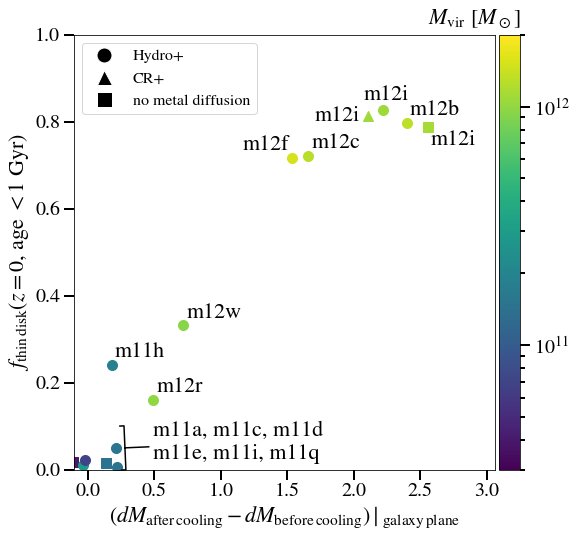

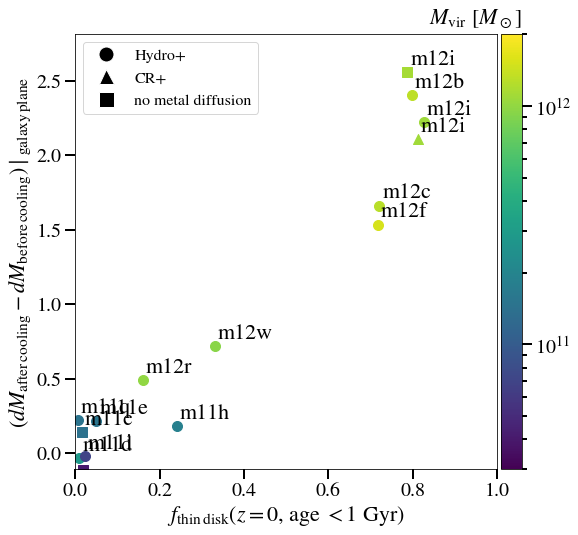

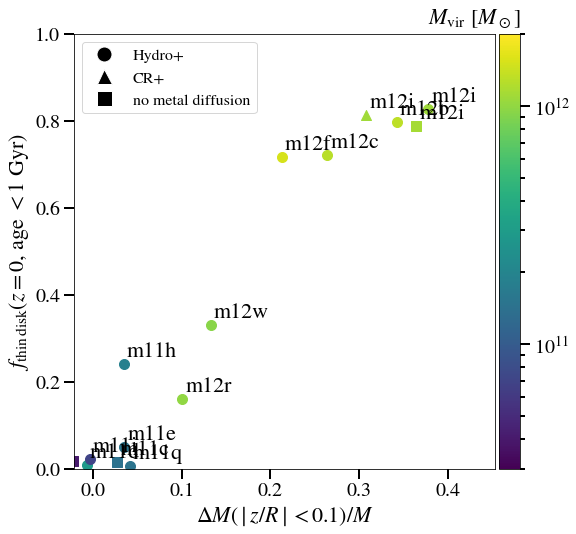

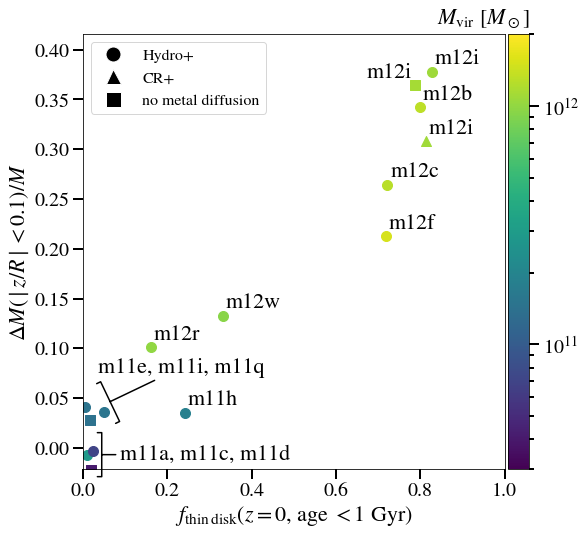

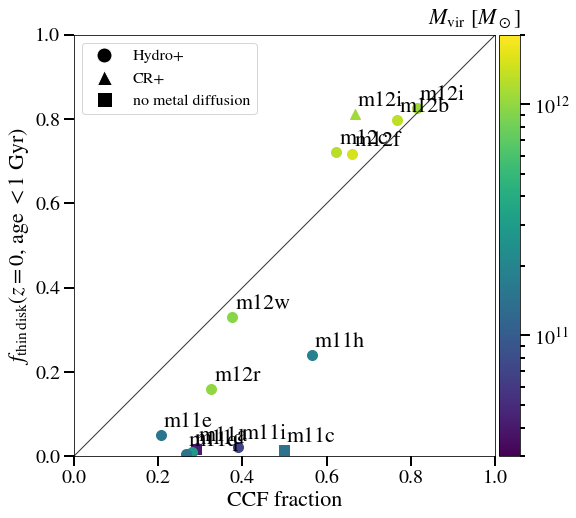

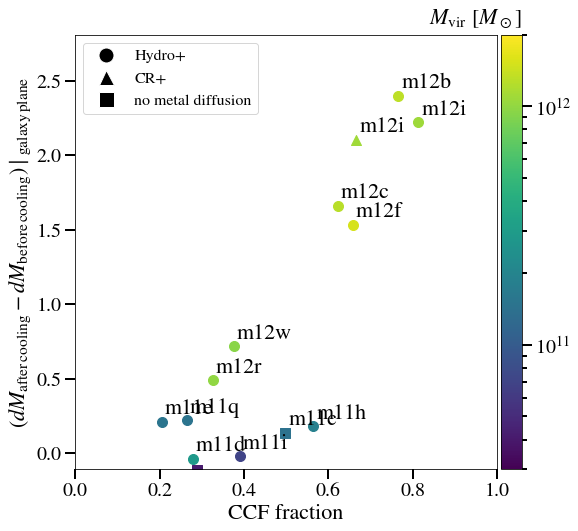

In [30]:
for i, (x_key, y_key, z_key) in enumerate( combinations ):
    
    xs = values[x_key]
    ys = values[y_key]
    zs = values[z_key]
    
    x_log = x_key in logscale
    y_log = y_key in logscale
    z_log = z_key in logscale
        
    x_lims = get_lim( xs, x_log, x_key, 1.2, 0.95 )
    y_lims = get_lim( ys, y_log, y_key, 1.1, 0.95 )
    z_lims = get_lim( zs, z_log, z_key, )

    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    for key in cp.variations :
        
        try:
            x = xs[key]
            y = ys[key]
            z = zs[key]
        except KeyError:
            continue
        
        if np.isnan( x ) or np.isnan( y ) or np.isnan( z ):
            continue
        elif not key in cp.variations:
            continue
        
        if '_' in key:
            sim_name, physics = key.split( '_' )
        else:
            sim_name = key
            physics = ''

        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
            
        s = ax.scatter(
            x,
            y,
            s = 100,
            color = c,
            marker = markers[physics]
        )

        # Annotate simulation names
        annot_args = {
            'textcoords': 'offset points',
            'fontsize': 22,
            'va': 'bottom',
            'ha': 'left',
            'xytext': ( 3, 3 ),
        }
        # Custom annotation arguments
        if ( x_key, y_key ) in custom_annot_args:
            if key in custom_annot_args[(x_key,y_key)]:
                custom_args = custom_annot_args[(x_key,y_key)][key]
                if custom_args is not None:
                    annot_args.update( custom_args )
                else:
                    annot_args = None
        if annot_args is not None:
            ax.annotate(
                text = sim_name,
                xy = ( x, y ),
                **annot_args
            )
        # Special cases
        if ( x_key, y_key ) == ( 'delta_pdfcosphi', 'thin_disk_frac_recent' ):
            if key == 'm11e_md':
                ax.annotate(
                    text = 'm11a, m11c, m11d\nm11e, m11i, m11q',
                    xy = ( x+0.05, y ),
                    xytext = ( 30, 5 ),
                    textcoords = 'offset points',
                    fontsize = 22,
                    va = 'center',
                    arrowprops = {
                        'arrowstyle': '-[',
                        'lw': 1.5,
                    },
                )
        elif ( x_key, y_key ) == ( 'thin_disk_frac_recent', 'delta_disk_frac' ):
            if key == 'm11e_md':
                ax.annotate(
                    text = 'm11e, m11i, m11q',
                    xy = ( x+0.01, y+0.01 ),
                    xytext = ( -10, 35 ),
                    textcoords = 'offset points',
                    fontsize = 22,
                    ha = 'left',
                    va = 'center',
                    arrowprops = {
                        'arrowstyle': '-[',
                        'lw': 1.5,
                    },
                )
            elif key == 'm11d_md':
                ax.annotate(
                    text = 'm11a, m11c, m11d',
                    xy = ( x+0.03, y ),
                    xytext = ( 20, 0 ),
                    textcoords = 'offset points',
                    fontsize = 22,
                    va = 'center',
                    arrowprops = {
                        'arrowstyle': '-[',
                        'lw': 1.5,
                    },
                )
        
    ax.set_xlabel( labels[x_key], fontsize=22 )
    ax.set_ylabel( labels[y_key], fontsize=22 )
    
    if x_log:
        ax.set_xscale( 'log' )
    if y_log:
        ax.set_yscale( 'log' )
    
    ax.set_xlim( x_lims )
    ax.set_ylim( y_lims )
    
    if x_key in fractions and y_key in fractions:
        ax.set_aspect( 'equal' )
        ax.plot(
            [ 0, 1 ],
            [ 0, 1 ],
            color = '.2',
            linewidth = 1,
        )
    
    # Legend
    legend_elements = [
        Line2D([0], [0], marker=markers[_], color='w', label=marker_labels[_], markerfacecolor='k', markersize=15)
        for _ in markers.keys()
    ]
    ax.legend(
        handles=legend_elements,
        prop = {'size': 16 },
    )
    
    # Colorbar
    if not z_log:
        norm_class = mpl.colors.Normalize
    else:
        norm_class = mpl.colors.LogNorm
    norm = norm_class(vmin=z_lims[0], vmax=z_lims[1])
    divider = make_axes_locatable( ax )
    cax = divider.append_axes( "right", pad=0.05, size='5%' )
    cbar = mpl.colorbar.ColorbarBase( cax, cmap=cmap, norm=norm, )
    
    # Colorbar label
    cax.annotate(
        text = labels[z_key],
        xy = (1,1),
        xytext = ( 0, 5 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        fontsize = 22,
        ha = 'right',
        va = 'bottom',
    )

## Multi-Panel

In [31]:
multipanel_combinations = [
    ( 'mvir', 'delta_disk_frac', 'thin_disk_frac_recent', ),
    ( 'mstar', 'delta_disk_frac', 'thin_disk_frac_recent', ),
]

In [32]:
cmap = palettable.matplotlib.Plasma_20.mpl_colormap

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/aligned_fraction_vs_galaxy_props.pdf


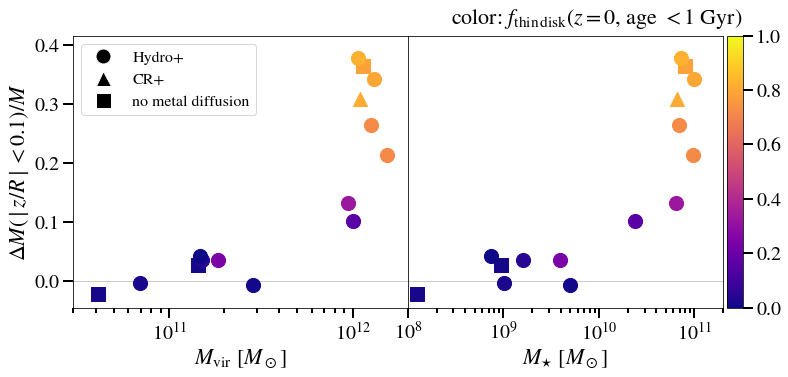

In [33]:
n_cols = len( multipanel_combinations )

fig = plt.figure( figsize=(6*n_cols,5), facecolor='w' )
main_ax = plt.gca()

gs = gridspec.GridSpec( 1, n_cols )
gs.update( wspace=0.0001 )

for i, (x_key, y_key, z_key) in enumerate( multipanel_combinations ):
    
    ax = plt.subplot(gs[0,i])
    
    xs = values[x_key]
    ys = values[y_key]
    zs = values[z_key]
    
    x_log = x_key in logscale
    y_log = y_key in logscale
    z_log = z_key in logscale
        
    x_lims = get_lim( xs, x_log, x_key, 1.2, )
    y_lims = get_lim( ys, y_log, y_key, 1.1, 2 )
    z_lims = get_lim( zs, z_log, z_key, )

    for key in cp.variations :
        
        try:
            x = xs[key]
            y = ys[key]
            z = zs[key]
        except KeyError:
            continue
        
        if np.isnan( x ) or np.isnan( y ) or np.isnan( z ):
            continue
            
        elif not key in cp.variations:
            continue
        
        if '_' in key:
            sim_name, physics = key.split( '_' )
        else:
            sim_name = key
            physics = ''

        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
            
        s = ax.scatter(
            x,
            y,
            s = 200,
            color = c,
            marker = markers[physics]
        )

#         # Annotate simulation names
#         annot_args = {
#             'textcoords': 'offset points',
#             'fontsize': 22,
#             'va': 'bottom',
#             'ha': 'left',
#             'xytext': ( 3, 3 ),
#         }
#         # Custom annotation arguments
#         if ( x_key, y_key ) in custom_annot_args:
#             if key in custom_annot_args[(x_key,y_key)]:
#                 custom_args = custom_annot_args[(x_key,y_key)][key]
#                 if custom_args is not None:
#                     annot_args.update( custom_args )
#                 else:
#                     annot_args = None
#         if annot_args is not None:
#             ax.annotate(
#                 s = sim_name,
#                 xy = ( x, y ),
#                 **annot_args
#             )
#         # Special cases
#         if ( x_key, y_key ) == ( 'delta_pdfcosphi', 'thin_disk_frac_recent' ):
#             if key == 'm11e_md':
#                 ax.annotate(
#                     s = 'm11a, m11c, m11d\nm11e, m11i, m11q',
#                     xy = ( x+0.05, y ),
#                     xytext = ( 30, 5 ),
#                     textcoords = 'offset points',
#                     fontsize = 22,
#                     va = 'center',
#                     arrowprops = {
#                         'arrowstyle': '-[',
#                         'lw': 1.5,
#                     },
#                 )
        
    ax.set_xlabel( labels[x_key], fontsize=22 )
    if ax.is_first_col():
        ax.set_ylabel( labels[y_key], fontsize=22 )
        
    # Zero line
    if y_key == 'delta_disk_frac':
        ax.axhline(
            0,
            color = '.8',
            linewidth = 1,
            zorder = -100,
        )

    if x_log:
        ax.set_xscale( 'log' )
    if y_log:
        ax.set_yscale( 'log' )

    ax.set_xlim( x_lims )
    ax.set_ylim( y_lims )

    if x_key in fractions and y_key in fractions:
        ax.set_aspect( 'equal' )
        ax.plot(
            [ 0, 1 ],
            [ 0, 1 ],
            color = '.2',
            linewidth = 1,
        )
        
    if not ax.is_first_col():
        ax.tick_params( left=False, labelleft=False )
    
    if ax.is_first_col():
        # Legend
        legend_elements = [
            Line2D([0], [0], marker=markers[_], color='w', label=marker_labels[_], markerfacecolor='k', markersize=15)
            for _ in markers.keys()
        ]
        ax.legend(
            handles=legend_elements,
            prop = {'size': 16 },
        )
    
    if ax.is_last_col():
        # Colorbar
        if not z_log:
            norm_class = mpl.colors.Normalize
        else:
            norm_class = mpl.colors.LogNorm
        norm = norm_class(vmin=z_lims[0], vmax=z_lims[1])
        divider = make_axes_locatable( ax )
        cax = divider.append_axes( "right", pad=0.05, size='5%' )
        cbar = mpl.colorbar.ColorbarBase( cax, cmap=cmap, norm=norm, )

        # Colorbar label
        cax.annotate(
            text = 'color: '+ labels[z_key],
            xy = (1,1),
            xytext = ( 0, 5 ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            fontsize = 22,
            ha = 'right',
            va = 'bottom',
        )
    
plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'prevalence' ),
    save_file = 'aligned_fraction_vs_galaxy_props.pdf',
    fig = fig,
)

## Connected Before-After

In [34]:
multi_values = {
    'sigma_cosphi': sigma_cosphi,
    'med_cosphi': med_cosphi,
    'abs_med_cosphi': abs_med_cosphi,
    'pdfcosphi_0': data['cosphi']['pdf(cos theta=0)'],
    'disk_frac': disk_frac,
}

In [35]:
rd_bu_cmap = palettable.scientific.diverging.Berlin_3_r.mpl_colors

In [36]:
annotate = False

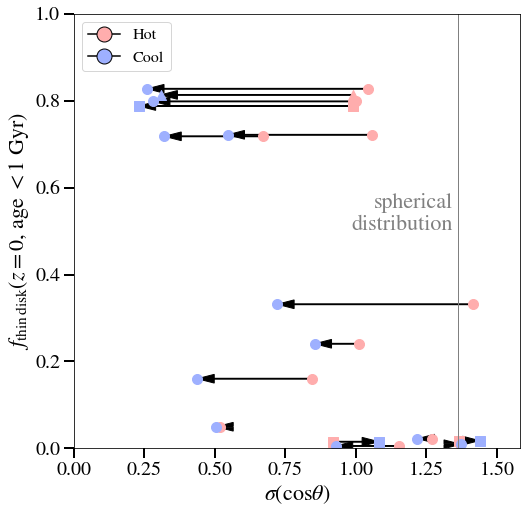

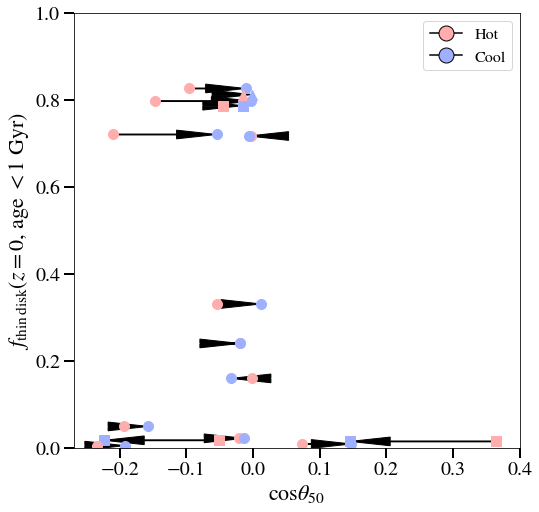

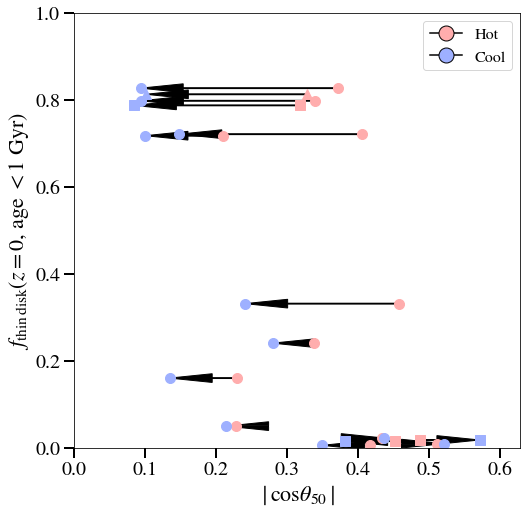

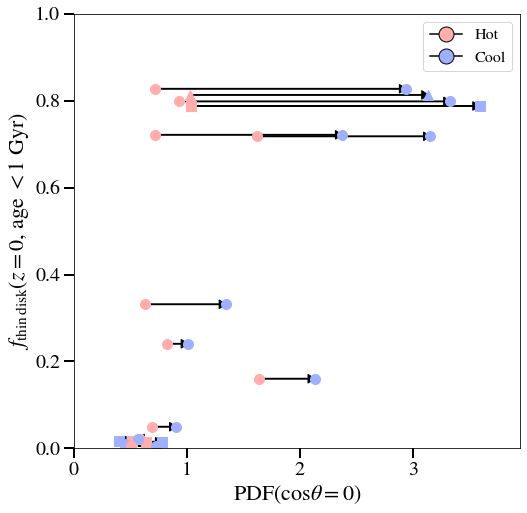

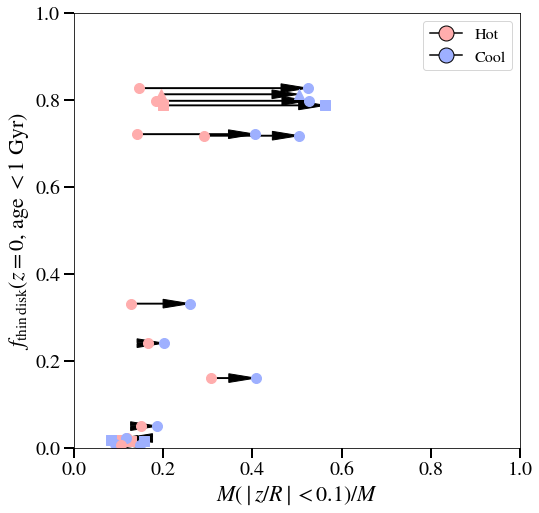

In [37]:
for x_key in multi_values.keys():

    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    y_key = 'thin_disk_frac_recent'

    xs = multi_values[x_key]
    xs_pre = xs.inner_item( 0 )
    xs_post = xs.inner_item( -1 )
    ys = values[y_key]

    x_log = x_key in logscale
    y_log = y_key in logscale
    z_log = z_key in logscale

    x_lims = get_lim( xs, x_log, x_key, 1.1 )
    y_lims = get_lim( ys, y_log, y_key, 1.1 )

    for key in cp.variations:

        try:
            x_pre = xs_pre[key]
            y = ys[key]
        except KeyError:
            continue

        if np.isnan( x_pre ):
            continue

        if '_' in key:
            sim_name, physics = key.split( '_' )
        else:
            sim_name = key
            physics = ''

        # Pre
        s = ax.scatter(
            x_pre,
            y,
            s = 100,
            color = rd_bu_cmap[0],
            marker = markers[physics]
        )
        s = ax.scatter(
            xs_post[key],
            y,
            s = 100,
            color = rd_bu_cmap[-1],
            marker = markers[physics]
        )

        if annotate:
            ax.annotate(
                text = sim_name,
                xy = ( x_pre, y ),
                xytext = ( 5, 5 ),
                textcoords = 'offset points',
                fontsize = 22,
                ha = 'left',
                va = 'bottom',
            )

        ax.arrow(
            x_pre, y,
            xs_post[key] - x_pre, 0,
    #         linewidth = 1.5,
            color = 'k',
            zorder = -100,
            width = 0.002,
            head_length = 0.06,
            head_width = 0.02,
            length_includes_head = True,
        )

    if x_key == 'sigma_cosphi':
        # Reference lines
        sigma_cosphi_sphere = 0.84 * 2 - 0.16 * 2
        ax.axvline(
            sigma_cosphi_sphere,
            color = '.5',
            linestyle = '-',
            linewidth = 1,
        )
        ax.annotate(
            text = 'spherical\ndistribution',
            xy = ( sigma_cosphi_sphere, 0.6 ),
            xycoords = 'data',
            xytext = ( -5, -5 ),
            textcoords = 'offset points',
            ha = 'right',
            va = 'top',
            fontsize = 22,
            color = '.5',
        )

    ax.set_xlabel( labels[x_key], fontsize=22 )
    ax.set_ylabel( labels[y_key], fontsize=22 )

    if x_log:
        ax.set_xscale( 'log' )
    if y_log:
        ax.set_yscale( 'log' )

    ax.set_xlim( x_lims )
    ax.set_ylim( y_lims )

    # Legend
    legend_labels = [ 'Hot', 'Cool' ]
    legend_elements = [
    Line2D([0], [0], marker='o', color='k', label=legend_labels[_], markerfacecolor=rd_bu_cmap[_], markersize=15)
    for _ in [ 0, -1 ]
    ]
    ax.legend(
    handles=legend_elements,
    prop = {'size': 16 },
    )

## Combined

In [38]:
multi_values = {
    'disk_frac': disk_frac,
}

In [39]:
rd_bu_cmap = palettable.scientific.diverging.Berlin_3_r.mpl_colors

In [40]:
cmap = palettable.matplotlib.Viridis_20.mpl_colormap

In [41]:
annotate = False

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/aligned_fraction.pdf


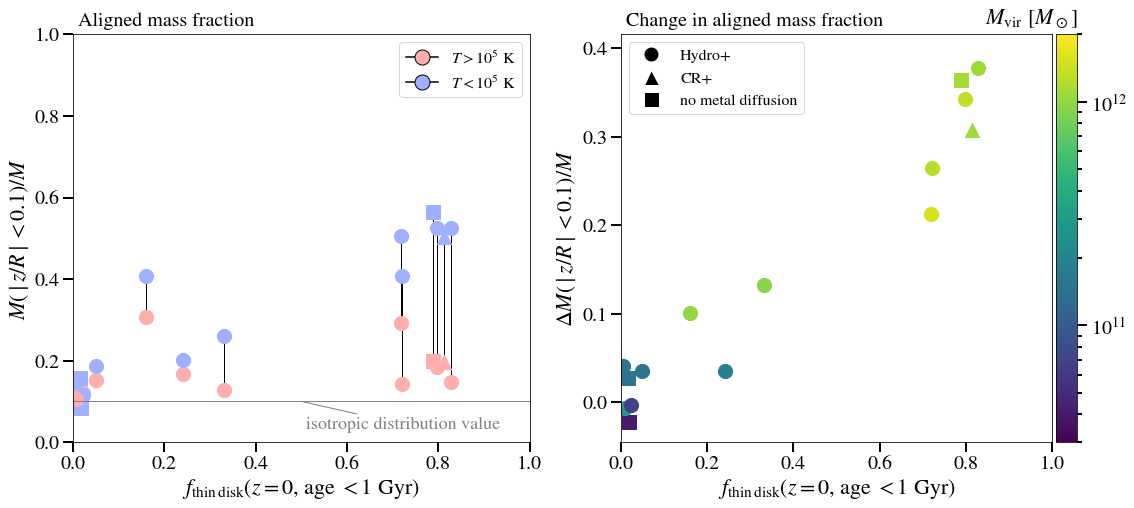

In [44]:
n_cols = 2
n_rows = 1
scale = 1.5

fig = plt.figure( figsize=(6*n_cols*scale,5*scale), facecolor='w' )
main_ax = plt.gca()

gs = gridspec.GridSpec( 1, n_cols )
#     gs.update( wspace=0.0001 )

x_key = 'thin_disk_frac_recent'
z_key = 'mvir'
y_key = 'disk_frac'

xs = values[x_key]
zs = values[z_key]
ys = values[y_key]
ys_pre = ys.inner_item( 0 )
ys_post = ys.inner_item( -1 )
ys_delta = ys_post - ys_pre

x_log = x_key in logscale
y_log = y_key in logscale
z_log = z_key in logscale

x_lims = get_lim( xs, x_log, x_key, 1.1 )
y_lims = get_lim( ys, y_log, y_key, 1.1 )

####################################################
# Left panel
####################################################

ax = plt.subplot( gs[0,0] )

for key in cp.variations:

    try:
        y_pre = ys_pre[key]
        x = xs[key]
    except KeyError:
        continue

    if np.isnan( x_pre ):
        continue

    if '_' in key:
        sim_name, physics = key.split( '_' )
    else:
        sim_name = key
        physics = ''

    # Pre
    s = ax.scatter(
        x,
        y_pre,
        s = 200,
        color = rd_bu_cmap[0],
        marker = markers[physics]
    )
    s = ax.scatter(
        x,
        ys_post[key],
        s = 200,
        color = rd_bu_cmap[-1],
        marker = markers[physics]
    )

    if annotate:
        ax.annotate(
            text = sim_name,
            xy = ( x, y_pre ),
            xytext = ( 5, 5 ),
            textcoords = 'offset points',
            fontsize = 22,
            ha = 'left',
            va = 'bottom',
        )
    ax.plot(
        [ x, x ],
        [ y_pre, ys_post[key] ],
        linewidth = 1,
        color = 'k',
        zorder = -100,
    )

if y_key == 'sigma_cosphi':
    # Reference lines
    sigma_cosphi_sphere = 0.84 * 2 - 0.16 * 2
    ax.axvline(
        sigma_cosphi_sphere,
        color = '.5',
        linestyle = '-',
        linewidth = 1,
    )
    ax.annotate(
        text = 'spherical\ndistribution',
        xy = ( sigma_cosphi_sphere, 0.6 ),
        xycoords = 'data',
        xytext = ( -5, -5 ),
        textcoords = 'offset points',
        ha = 'right',
        va = 'top',
        fontsize = 22,
        color = '.5',
    )
elif y_key == 'disk_frac':
    ax.axhline(
        pm['disk_costheta'],
        color = '.5',
        linestyle = '-',
        linewidth = 1,
    )
    ax.annotate(
        text = 'isotropic distribution value',
        xy = ( 0.5, pm['disk_costheta'] ),
        xycoords = 'data',
        xytext = ( 5, -15 ),
        textcoords = 'offset points',
        ha = 'left',
        va = 'top',
        fontsize = 18,
        color = '.5',
        arrowprops = { 'arrowstyle': '-', 'color': '.5', },
    )


ax.set_xlabel( labels[x_key], fontsize=22 )
ax.set_ylabel( labels[y_key], fontsize=22 )

ax.annotate(
    text = 'Aligned mass fraction',
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 20,
    ha = 'left',
    va = 'bottom',
)

if x_log:
    ax.set_xscale( 'log' )
if y_log:
    ax.set_yscale( 'log' )

ax.set_xlim( x_lims )
ax.set_ylim( y_lims )

# Legend
legend_labels = [ r'$T > 10^5$ K', r'$T < 10^5$ K' ]
legend_elements = [
Line2D([0], [0], marker='o', color='k', label=legend_labels[_], markerfacecolor=rd_bu_cmap[_], markersize=15)
for _ in [ 0, -1 ]
]
ax.legend(
handles=legend_elements,
prop = {'size': 16 },
)

####################################################
# Right panel
####################################################

y_key = 'delta_' + y_key

x_lims = get_lim( xs, x_log, x_key, 1.2, )
y_lims = get_lim( ys_delta, y_log, y_key, 1.1, 2 )
z_lims = get_lim( zs, z_log, z_key, )

ax = plt.subplot(gs[0,1])

for key in cp.variations :

    try:
        x = xs[key]
        y = ys_delta[key]
        z = zs[key]
    except KeyError:
        continue

    if np.isnan( x ) or np.isnan( y ) or np.isnan( z ):
        continue
    elif not key in cp.variations:
        continue

    if '_' in key:
        sim_name, physics = key.split( '_' )
    else:
        sim_name = key
        physics = ''

    if not z_log:
        c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
    else:
        c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
    c = cmap( c_value )

    s = ax.scatter(
        x,
        y,
        s = 200,
        color = c,
        marker = markers[physics]
    )

ax.set_xlabel( labels[x_key], fontsize=22 )
ax.set_ylabel( labels[y_key], fontsize=22 )

ax.annotate(
    text = 'Change in aligned mass fraction',
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 5, 5 ),
    textcoords = 'offset points',
    fontsize = 20,
    ha = 'left',
    va = 'bottom',
)

if x_log:
    ax.set_xscale( 'log' )
if y_log:
    ax.set_yscale( 'log' )

ax.set_xlim( x_lims )
ax.set_ylim( y_lims )

if x_key in fractions and y_key in fractions:
    ax.set_aspect( 'equal' )
    ax.plot(
        [ 0, 1 ],
        [ 0, 1 ],
        color = '.2',
        linewidth = 1,
    )

# Legend
legend_elements = [
    Line2D([0], [0], marker=markers[_], color='w', label=marker_labels[_], markerfacecolor='k', markersize=15)
    for _ in markers.keys()
]
ax.legend(
    handles=legend_elements,
    prop = {'size': 16 },
)

# Colorbar
if not z_log:
    norm_class = mpl.colors.Normalize
else:
    norm_class = mpl.colors.LogNorm
norm = norm_class(vmin=z_lims[0], vmax=z_lims[1])
divider = make_axes_locatable( ax )
cax = divider.append_axes( "right", pad=0.05, size='5%' )
cbar = mpl.colorbar.ColorbarBase( cax, cmap=cmap, norm=norm, )

# Colorbar label
cax.annotate(
    text = labels[z_key],
    xy = (1,1),
    xytext = ( 0, 5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 22,
    ha = 'right',
    va = 'bottom',
)

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'prevalence' ),
    save_file = 'aligned_fraction.pdf',
    fig = fig,
)